In [1]:
import numpy as np
import pandas as pd
import random
from pandas import read_csv
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import scipy.io


In [2]:
mat      = scipy.io.loadmat('binned_zscore.mat') 
Behavior = scipy.io.loadmat('binned_behavior.mat')

In [3]:
zscore = pd.DataFrame(mat['binned_zscore'])
behavior = pd.DataFrame(Behavior['binned_behavior']).T
behavior.columns = ['behavior_1', 'behavior_2']

behavior.head()

# drop_index = np.where((behavior[0, :] + behavior[1, :]) == 0)
# zscore = np.delete(zscore, drop_index, axis = 1)
# behavior = np.delete(behavior, drop_index, axis = 1)

# merge data_maze and data_maze_behavior
df_merge = pd.concat([zscore, behavior], axis=1)

df_merge = df_merge[(df_merge['behavior_1'] != 0) | (df_merge['behavior_2'] != 0)]
df_merge.drop(['behavior_2'], axis=1, inplace=True)

print(df_merge.shape)

(6184, 111)


In [4]:
df_train_ts = df_merge.iloc[:int(len(df_merge)*0.7)]
df_train_ts.shape

# get the x and y
# x_train_ts = df_train_ts.drop(['behavior_1'], axis=1)
# y_train_ts = df_train_ts['behavior_1']

# get the rest 30% rows as testset
df_test_ts = df_merge.iloc[int(len(df_merge)*0.7):]
df_test_ts.shape

# get the x and y
# x_test_ts = df_test_ts.drop(['behavior_1'], axis=1)
# y_test_ts = df_test_ts['behavior_1']


# change the data into time series

(1856, 111)

In [5]:
# get the x and y
df_y = df_merge['behavior_1'].values
df_x = df_merge.drop('behavior_1', axis=1).values
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of time points we want to look into the future based on the past days.
n_past = 5  # Number of past time points we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (4328, 110)
#4328 refers to the number of data points and 111 refers to the columns (multi-variables).
for i in range(n_past, len(df_x) - n_future +1):
    trainX.append(df_x[(i - n_past):i, 0:df_x.shape[1]])
    trainY.append(df_y[(i + n_future - 1):(i + n_future)])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (6179, 5, 110).
trainY shape == (6179, 1).


In [6]:
cols = list(df_train_ts)[0:111]
#Date and volume columns are not used in training.
print(cols) #['0', '1', ..., '109', 'behavior_1']

#New dataframe with only training data - 110 columns
df_for_training = df_train_ts[cols].astype("float")
df_for_testing = df_test_ts[cols].astype("float")

# another way to capture the training data without the behavior_1 column
df_y_train = df_train_ts['behavior_1']
df_y_test = df_test_ts['behavior_1']
df_x_for_training = df_for_training.drop('behavior_1', axis=1)
df_x_for_testing = df_for_testing.drop('behavior_1', axis=1)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler1 = scaler.fit(df_x_for_training)
df_for_training_scaled = scaler1.transform(df_x_for_training)
scaler2 = scaler.fit(df_x_for_testing)
df_for_testing_scaled = scaler2.transform(df_x_for_testing)

# if we don't use scale, we just transform the data into a numpy array
# df_for_training_scaled = df_x_for_training.values
# df_for_testing_scaled = df_x_for_testing.values

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training).

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of time points we want to look into the future based on the past days.
n_past = 5  # Number of past time points we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (4328, 110)
#4328 refers to the number of data points and 111 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[(i - n_past):i, 0:df_for_training_scaled.shape[1]])
    trainY.append(df_y_train[(i + n_future - 1):(i + n_future)])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


testX = []
testY = []
for i in range(n_past, len(df_for_testing_scaled) - n_future +1):
    testX.append(df_for_testing_scaled[(i - n_past):i, 0:df_for_testing_scaled.shape[1]])
    testY.append(df_y_test[(i + n_future - 1):(i + n_future)])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

# another way to capture the training data without the loop
# trainX = df_for_training_scaled[:int(len(df_for_training_scaled)*0.7), 0:df_for_training_scaled.shape[1]]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 'behavior_1']
trainX shape == (4323, 5, 110).
trainY shape == (4323, 1).
testX shape == (1851, 5, 110).
testY shape == (1851, 1).


In [127]:
# tr_zscore = []
# for i in range(110):
#     tr_zscore.append(make_windows(zscore[i, :], 5, 1))
# tr_zscore = np.asarray(tr_zscore)
# window_zscore = []
# for i in range(6180):
#     window_zscore.append(tr_zscore[:, i, :])
# window_zscore = np.asarray(window_zscore)
# window_zscore.shape

(6180, 110, 5)

In [11]:
# apply LSTM to the data
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

import tensorflow as tf

# define the model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True,input_shape=(trainX.shape[1], trainX.shape[2]), activation='relu'))
model.add(LSTM(units=32, activation='relu', return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(trainY.shape[1], activation='sigmoid'))

# define a GRU model
# model = Sequential()
# model.add(GRU(units=64, return_sequences=True,input_shape=(trainX.shape[1], trainX.shape[2]), activation='relu'))
# model.add(GRU(units=32, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(trainY.shape[1], activation='sigmoid'))

# decay learning rate
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=100,
#     decay_rate=0.96,
#     staircase=True)

# model.compile(optimizer=SGD(learning_rate=0.01), loss = 'binary_crossentropy', metrics=['accuracy'])

model.compile(optimizer=Adam(learning_rate=0.00001), loss = 'binary_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 64)             44800     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 57,249
Trainable params: 57,249
Non-trainable params: 0
_________________________________________________________________


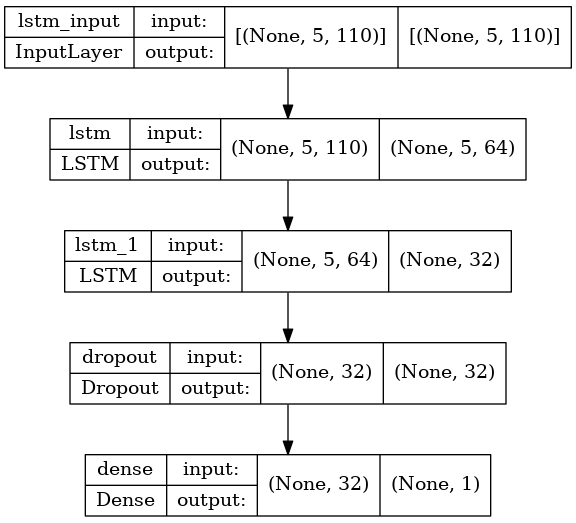

In [8]:
# build the type of the model
tf.keras.utils.plot_model(
    model, dpi=96,
    show_shapes=True, show_layer_names=True,
    expand_nested=False
)

In [12]:
# early stopping
from tensorflow.keras.callbacks import EarlyStopping
callback=EarlyStopping(
    monitor='val_loss', min_delta=0, patience=6, verbose=2, mode='auto',
    baseline=None, restore_best_weights=False
)


# fit the model
history = model.fit(trainX, trainY,validation_data=(testX, testY), epochs=60, batch_size=16, validation_freq=1,callbacks=[callback])



Epoch 1/60
271/271 [==============================] - 7s 19ms/step - loss: 0.6826 - accuracy: 0.5788 - val_loss: 0.6586 - val_accuracy: 0.7374
Epoch 2/60
271/271 [==============================] - 5s 17ms/step - loss: 0.6592 - accuracy: 0.6424 - val_loss: 0.6360 - val_accuracy: 0.7563
Epoch 3/60
271/271 [==============================] - 5s 18ms/step - loss: 0.6385 - accuracy: 0.6694 - val_loss: 0.6143 - val_accuracy: 0.7709
Epoch 4/60
271/271 [==============================] - 5s 17ms/step - loss: 0.6191 - accuracy: 0.7118 - val_loss: 0.5929 - val_accuracy: 0.7817
Epoch 5/60
271/271 [==============================] - 5s 17ms/step - loss: 0.5959 - accuracy: 0.7395 - val_loss: 0.5712 - val_accuracy: 0.7904
Epoch 6/60
271/271 [==============================] - 5s 17ms/step - loss: 0.5770 - accuracy: 0.7458 - val_loss: 0.5508 - val_accuracy: 0.7947
Epoch 7/60
271/271 [==============================] - 5s 17ms/step - loss: 0.5590 - accuracy: 0.7534 - val_loss: 0.5302 - val_accuracy: 0.7985

In [17]:
def plot_acc_loss(result, epochs):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.ylim(0, 1)
    plt.xlim(1, epochs - 1)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.xlim(1, epochs - 1)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()

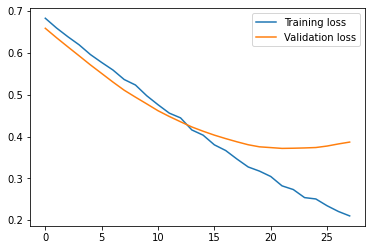

Accuracy: 0.8314424635332253


In [13]:
# plot the loss and accuracy
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

prediction_prob = model.predict(testX)
prediction = np.round(prediction_prob)
# df_1 = pd.DataFrame(prediction, columns=['prediction'])
# df_1['prediction_prob'] = prediction_prob
accuracy_1 = np.mean(prediction==testY)
print('Accuracy: {}'.format(accuracy_1))

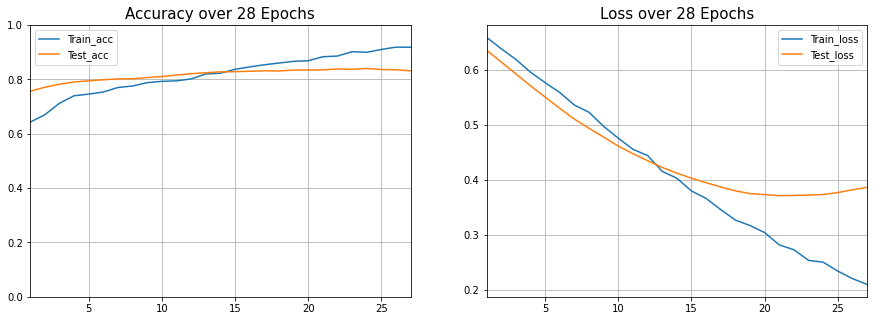

In [19]:
plot_acc_loss(history, 28)